In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, SimpleRNN
import matplotlib.pyplot as plt
import os


In [2]:
print(tf.__version__)


2.3.1


In [3]:
input_word = 'abcde'
w_to_id = {}
for index, i in enumerate(input_word):
    w_to_id[i] = index
print(w_to_id)

{'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4}


In [4]:
import pprint
id_to_onehot = {}
a = tf.one_hot(indices=list(w_to_id.values()), depth=5)
for index, j in enumerate(a):
    id_to_onehot[index] = j.numpy().tolist()
pprint.pprint(id_to_onehot)
'''
  ```python
  indices = [0, 1, 2]
  depth = 3
  tf.one_hot(indices, depth)  # output: [3 x 3]
  # [[1., 0., 0.],
  #  [0., 1., 0.],
  #  [0., 0., 1.]]
  '''

{0: [1.0, 0.0, 0.0, 0.0, 0.0],
 1: [0.0, 1.0, 0.0, 0.0, 0.0],
 2: [0.0, 0.0, 1.0, 0.0, 0.0],
 3: [0.0, 0.0, 0.0, 1.0, 0.0],
 4: [0.0, 0.0, 0.0, 0.0, 1.0]}


'\n  ```python\n  indices = [0, 1, 2]\n  depth = 3\n  tf.one_hot(indices, depth)  # output: [3 x 3]\n  # [[1., 0., 0.],\n  #  [0., 1., 0.],\n  #  [0., 0., 1.]]\n  '

In [5]:
x_train = list(id_to_onehot.values())
y_train = list(w_to_id.values())
y_train.remove(0)
y_train.append(0)
pprint.pprint(x_train)
print(y_train)

[[1.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 1.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 1.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 1.0]]
[1, 2, 3, 4, 0]


In [6]:
np.random.seed(7)
np.random.shuffle(x_train)
np.random.seed(7)
np.random.shuffle(y_train)
tf.random.set_seed(7)

In [7]:
x_train = np.reshape(x_train, (len(x_train), 1, 5))
y_train = np.array(y_train)
print(x_train)
print(y_train)

[[[1. 0. 0. 0. 0.]]

 [[0. 0. 0. 1. 0.]]

 [[0. 0. 1. 0. 0.]]

 [[0. 1. 0. 0. 0.]]

 [[0. 0. 0. 0. 1.]]]
[1 4 3 2 0]


In [8]:
model = tf.keras.Sequential([
    SimpleRNN(3),
    Dense(5, activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['sparse_categorical_accuracy']
              )

In [9]:
print(x_train, y_train)

[[[1. 0. 0. 0. 0.]]

 [[0. 0. 0. 1. 0.]]

 [[0. 0. 1. 0. 0.]]

 [[0. 1. 0. 0. 0.]]

 [[0. 0. 0. 0. 1.]]] [1 4 3 2 0]


-------------load the model-----------------
Epoch 1/100
1/1 [==============================] - 0s 28ms/step - loss: 1.5841 - sparse_categorical_accuracy: 0.6000
Epoch 2/100
1/1 [==============================] - 0s 23ms/step - loss: 1.5726 - sparse_categorical_accuracy: 0.6000
Epoch 3/100
1/1 [==============================] - 0s 16ms/step - loss: 1.5553 - sparse_categorical_accuracy: 0.6000
Epoch 4/100
1/1 [==============================] - 0s 21ms/step - loss: 1.5336 - sparse_categorical_accuracy: 0.6000
Epoch 5/100
1/1 [==============================] - 0s 16ms/step - loss: 1.5087 - sparse_categorical_accuracy: 0

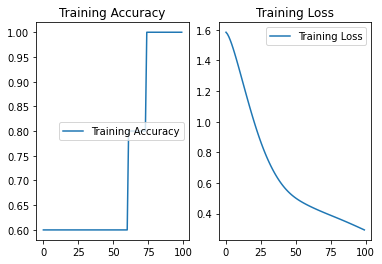

In [10]:
checkpoint_save_path = "./checkpoint/rnn_onehot_1pre1.ckpt"

if os.path.exists(checkpoint_save_path + '.index'):
    print('-------------load the model-----------------')
    model.load_weights(checkpoint_save_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 monitor='loss')  # 由于fit没有给出测试集，不计算测试集准确率，根据loss，保存最优模型

history = model.fit(x_train, y_train, batch_size=32, epochs=100, callbacks=[cp_callback])

model.summary()

# print(model.trainable_variables)
file = open('./weights.txt', 'w')  # 参数提取
for v in model.trainable_variables:
    file.write(str(v.name) + '\n')
    file.write(str(v.shape) + '\n')
    file.write(str(v.numpy()) + '\n')
file.close()

###############################################    show   ###############################################

# 显示训练集和验证集的acc和loss曲线
acc = history.history['sparse_categorical_accuracy']
loss = history.history['loss']

plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

In [11]:
############### predict #############

preNum = int(input("input the number of test alphabet:"))
for i in range(preNum):
    alphabet1 = input("input test alphabet:")
    alphabet = [id_to_onehot[w_to_id[alphabet1]]]
    # 使alphabet符合SimpleRNN输入要求：[送入样本数， 循环核时间展开步数， 每个时间步输入特征个数]。此处验证效果送入了1个样本，送入样本数为1；输入1个字母出结果，所以循环核时间展开步数为1; 表示为独热码有5个输入特征，每个时间步输入特征个数为5
    alphabet = np.reshape(alphabet, (1, 1, 5))
    result = model.predict([alphabet])
    pred = tf.argmax(result, axis=1)
    pred = int(pred)
    tf.print(alphabet1 + '->' + input_word[pred])


Consider rewriting this model with the Functional API.
a->b
b->c
c->d
d->e
e->a
